LHAPDF 6.5.4 loading all 49 PDFs in set CJ15nlo_mod
CJ15nlo_mod, version 1; 49 PDF members
LHAPDF 6.5.4 loading all 49 PDFs in set CJ15nlo
CJ15nlo, version 2; 49 PDF members
LHAPDF 6.5.4 loading all 59 PDFs in set CT18NNLO
CT18NNLO, version 1; 59 PDF members


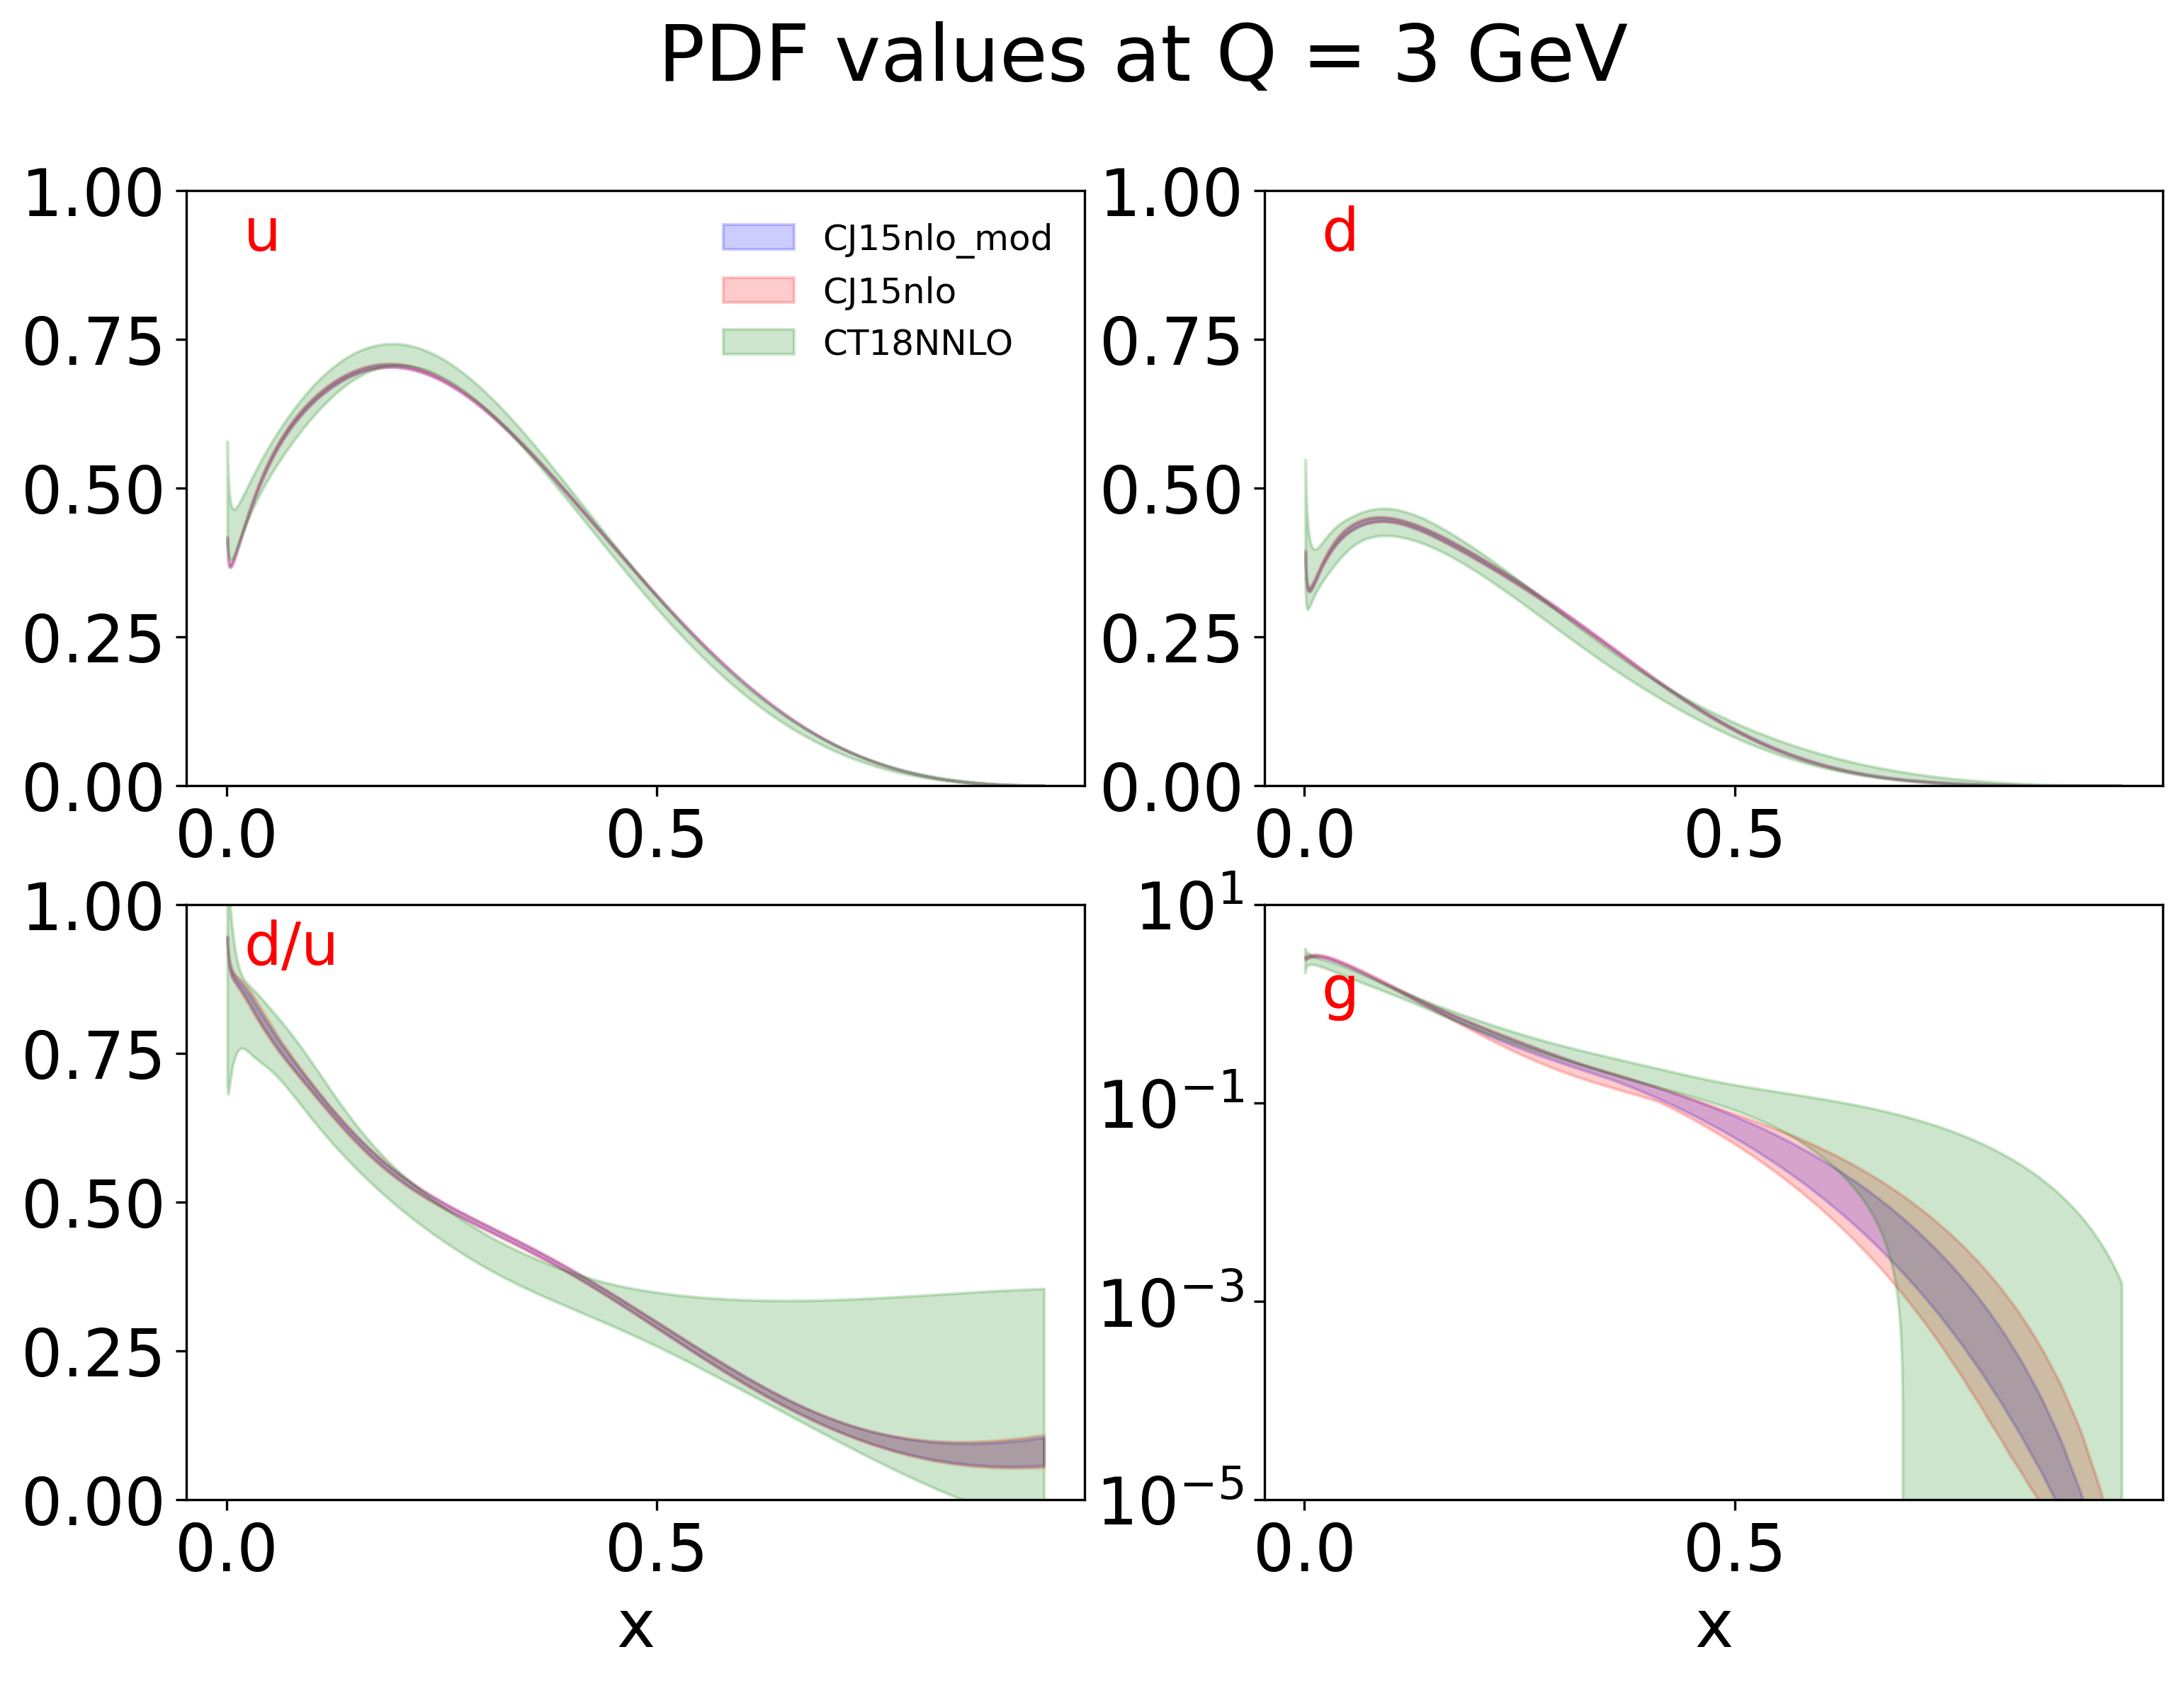

In [42]:
# example python code to plot CJ15nlo_mod PDF with LHAPDF. 
# to install LHAPDF, follow instructions at https://lhapdf.hepforge.org
# to download CJ15nlo_mod grids, visit https://www.jlab.org/theory/cj
# also check https://github.com/JeffersonLab/CJ-database/
# Shujie Li, Sep 2024 

import numpy as np
import lhapdf
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(9,6)
plt.rcParams['font.size'] = 22

## dict for quark flavor
proj   = {'d':1,'u':2,'s':3,'c':4,'b':5,'db':-1,'ub':-2,'sb':-3,'cb':-4,'bb':-5,'g':21}

def quark(pdf,v,Q,flavor):
    return pdf.xfxQ2(proj[flavor], v, Q)

## d/u ratio
def d_u(pdf,v,Q,flavor="dummy"):
    return pdf.xfxQ2(proj['d'], v, Q)/pdf.xfxQ2(proj['u'], v, Q) if pdf.xfxQ2(proj['u'], v, Q)!= 0 else 0

## estimate error band (asymmetric), see eq7 in 10.1103/PhysRevD.87.094012
def err_plus(err_list,expr,v,Q,flavor):
    # dof        = 24 ## CJ15, 24 free params --> 24*2 error PDF sets + 1 central set
    dof = int((len(err_list)-1)/2)
    return np.sqrt(sum([max(expr(err_list[2*i-1],v,Q,flavor) - expr(err_list[0],v,Q,flavor),
                    expr(err_list[2*i],v,Q,flavor) - expr(err_list[0],v,Q,flavor),
                    0)**2
            for i in range(1,dof+1)]))

def err_minus(err_list,expr,v,Q,flavor):
#     return 0
    dof = int((len(err_list)-1)/2)
    return np.sqrt(
        sum(
            [max(-expr(err_list[2*i-1],v,Q,flavor) + expr(err_list[0],v,Q,flavor),
                    -expr(err_list[2*i],v,Q,flavor) + expr(err_list[0],v,Q,flavor),
                    0)**2
            for i in range(1,dof+1)]
        )
    )

def R_s(x,Q,p):
    s = p.xfxQ(proj['s'], x, Q)
    sb = p.xfxQ(proj['sb'], x, Q)
    ub = p.xfxQ(proj['ub'], x, Q)
    db = p.xfxQ(proj['db'], x, Q)
    if ub+db > 0:
        return (s+sb)/(ub+db)
    return 0


## plot multiple PDF sets
def compare_pdf(set1,set2="",set3="",Q=3):
    k2 = 0
    k3 = 0
    if len(set2)>0:
        k2=1
    if len(set3)>0:
        k3=1
        
    set1_err   = lhapdf.mkPDFs(set1)
    if k2:
        set2_err   = lhapdf.mkPDFs(set2)
    if k3:
        set3_err   = lhapdf.mkPDFs(set3)

    x = np.linspace(0.001,0.85,1000)

    nn = len(pdflist)
    m  = nn//2
    n  = nn%2
    fig, axs = plt.subplots(m,2,figsize=(12,8),dpi=300)
    fig.suptitle('PDF values at Q = '+ str(Q) + ' GeV')#, fontsize="x-large")

    x = np.linspace(0.001,0.95,1000)
    ## calculate error band
    def yp(erset, pdfname):
        if pdfname=='d/u':
            return [d_u(erset[0],v,Q)+err_plus(erset,d_u,v,Q,pdfname) for v in x]
        return [quark(erset[0],v,Q,pdfname)+err_plus(erset,quark,v,Q,pdfname) for v in x]
    def ym(erset, pdfname):
        if pdfname=='d/u':
            return [d_u(erset[0],v,Q)-err_minus(erset,d_u,v,Q,pdfname) for v in x]
        return [quark(erset[0],v,Q,pdfname)-err_minus(erset,quark,v,Q,pdfname) for v in x]
                
    for i in range(nn):
        pname = pdflist[i]
        m = i//2
        n = i%2

        axs[m][n].fill_between(x, yp(set1_err,pname), ym(set1_err,pname),
                         facecolor="blue", # The fill color
                         color='blue',       # The outline color
                         alpha=0.2)
        if k2>0:
            axs[m][n].fill_between(x, yp(set2_err,pname), ym(set2_err,pname),
                         facecolor="red", # The fill color
                         color='red',       # The outline color
                         alpha=0.2)
        if k3>0:
            axs[m][n].fill_between(x, yp(set3_err,pname), ym(set3_err,pname),
                         facecolor="g", # The fill color
                         color='g',       # The outline color
                         alpha=0.2)
        axs[m][n].set_ylim(0,1)
        axs[m][n].text(0.02,0.9,pname,c="r",fontsize=20)
        ## log scale for gluon
        if pname=="g":
            axs[m][n].set_yscale('log')
            axs[m][n].set_ylim(0.00001,10)
            axs[m][n].text(0.02,0.9,pname,c="r",fontsize=20)


    axs[0][0].legend((set1,set2,set3),loc="upper right",fontsize=12,frameon=False)
    axs[m][n].set_xlabel("x")    
    axs[m][n-1].set_xlabel("x")    
    plt.savefig("compare_pdf.png")  
    plt.show()

if __name__ == "__main__":
    ## if the grids path are not included in LHAPDF_PATH, add it manually 
    # path_to_grids=""
    # lhapdf.pathsPrepend(path_to_grids)
    # print(lhapdf.availablePDFSets())
    # print(lhapdf.paths())
    pdflist= ['u','d','d/u','g'] ## global variable
    compare_pdf("CJ15nlo_mod","CJ15nlo","CT18NNLO",Q=3)
